# Part 1

In [1]:
#Import Libraries
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
#Share Specific Information
r = 0.08 #risk-free continuously compounded interest rate 
S0 = 100 #current share price 
v0 = 0.06
kappa = 9
theta = 0.06
sigma = 0.3
rho = -0.4

#Call Specific Information
K = 100
T = 1
k_log = np.log(K)

#Approximation Information

t_max = 30
N = 100

In [3]:
#Characteristic function code

a = sigma**2/2

def b(u):
    return kappa - rho*sigma*1j*u

def c(u):
    return -(u**2+1j*u)/2

def d(u):
    return np.sqrt(b(u)**2-4*a*c(u))

def xminus(u):
    return (b(u)-d(u))/(2*a)

def xplus(u):
    return (b(u)+d(u))/(2*a)

def g(u):
    return xminus(u)/xplus(u)

def C(u):
    val1 = T*xminus(u)-np.log((1-g(u)*np.exp(-T*d(u)))/(1-g(u)))/a
    return r*T*1j*u + theta*kappa*val1

def D(u):
    val1 = 1-np.exp(-T*d(u))
    val2 = 1-g(u)*np.exp(-T*d(u))
    return (val1/val2)*xminus(u)

def log_char(u):
    return np.exp(C(u) + D(u)*v0 + 1j*u*np.log(S0))

def adj_char(u):
    return log_char(u-1j)/log_char(-1j)

In [4]:
delta_t = t_max/N
from_1_to_N = np.linspace(1,N,N)
t_n = (from_1_to_N-1/2)*delta_t

#Integral calculations
first_integral = sum((((np.exp(-1j*t_n*k_log)*adj_char(t_n)).imag)/t_n)*delta_t)
second_integral = sum((((np.exp(-1j*t_n*k_log)*log_char(t_n)).imag)/t_n)*delta_t)

#Call value
fourier_call_val = S0*(1/2 + first_integral/np.pi)-np.exp(-r*T)*K*(1/2 + second_integral/np.pi)
fourier_call_val

13.734895692109049

# Part 2

Assume that $\sigma(t_i,t_{i+1}) = \sigma(S_{ti})^{\gamma-1}$, where $\sigma = 0.3$ and $\gamma = 0.75$. Using the formula below, simulate paths for the underlying share using sample sizes of 1000, 2000, …, 50000. Perform monthly simulations for a period of a year. We can simulate the next step in a share price path using the following formula:
$$S_{t_{i+1}} = S_{t_i}e^{(r - \frac{\sigma^2 (t_i,t_{i+1})}{2})(t_{i+1}-t_i)+\sigma(t_i, t_{i+1})\sqrt{t_{i+1}-t_i}Z}$$
where $S_{ti}$ is the share price at time $t_i$, $\sigma(t_i, t_{i+1})$ is the volatility for the period $[t_i,t_{i+1}]$, r is the risk-free interest rate, and Z~N(0, 1)

Note that we are attempting to run simulations using the CEV model. However, while the CEV model assumes that volatility is a continuous function of time and share price, we are making a simplifying assumption that volatility is constant over each simulation period.

In [5]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

In [63]:
#from question
sigma_const = 0.3
gamma = 0.75

#assumption
r = 0.08
S0 = 100
T = 1
sample_sizes = range(1000, 50001, 1000)

timesteps = 12

First, we define our helper functions. The next_share_price function is used to calculate the evolution of the share price at t+1, from the share price at t. We generate the random variable Z from within this function. The effective sigma is also written as a function of the share price at t. 

Just for exploration purposes, we also added a varying_vol flag, to allow us to switch between a constant volatility and varying volatility. We use the initial stock price instead of the previous price when assuming a contant volatility.

The other function is the generate_share_price_path function. We first create an empty numpy array of shape (sample_size x timesteps+1). Note the addition of one element to the timestep, as the first element is equal to the initial stock price. We then iterate through each path, and each timestep, applying the next_share_price function against the previous share price. We then convert the result into a pandas DataFrame and return the results.

In [97]:
def next_share_price(prev_price, r, dT, sigma_const, gamma, sample_size, varying_vol = True):
    Z = stats.norm.rvs(size=sample_size)
    if varying_vol:
        sigma = sigma_const*(prev_price)**(gamma-1)
    else:
        sigma = sigma_const*(S0)**(gamma-1)
        
    return prev_price*np.exp((r-(sigma**2)/2)*(dT)+(sigma)*(np.sqrt(dT))*Z)

def generate_share_price_path(S0, r, T, sigma_const, gamma, sample_size, timesteps, varying_vol = True):
    result = np.empty(shape=(sample_size, T*(timesteps+1))) #One additional timestep row as first row is just the initial share price
    
    df = pd.DataFrame([S0]*sample_size)
    for t in range(1, timesteps+1):
        df[t] = next_share_price(df[t-1], r, 1/timesteps, sigma_const, gamma, sample_size, varying_vol)
    return df.T


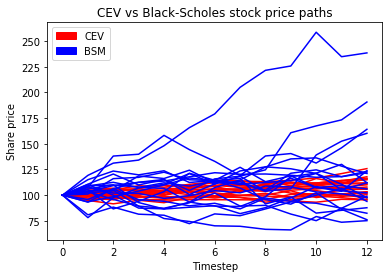

In [99]:
import matplotlib.patches as mpatches
T = 10
sample_size = 20

share_price_path_cev = generate_share_price_path(S0, r, T, sigma_const, gamma, sample_size, timesteps)
share_price_path_black_scholes = generate_share_price_path(S0, r, T, sigma_const, 1.0, sample_size, timesteps, varying_vol=False)

plt.plot(share_price_path_cev, color='red')
plt.plot(share_price_path_black_scholes, color='blue')
plt.xlabel("Timestep")
plt.ylabel("Share price")
red_patch = mpatches.Patch(color='red', label='CEV')
blue_patch = mpatches.Patch(color='blue', label='BSM')
plt.legend(handles=[red_patch, blue_patch], loc='upper left')
plt.title("CEV vs Black-Scholes stock price paths")
plt.show()

Next, we create a python dictionary called share_price_paths, to hold our results for part 2. The key of this dictionary would be the number of sample price paths, while the values would be the dataframes containing the price paths. We also track the rough processing time required at each step, by printing the time when each iteration completes.

In [100]:
import time

T = 1
sample_sizes = range(1000, 50001, 1000)

share_price_paths = {}

print("Start generating share price path")
start = time.time()
for sample_size in sample_sizes:
    share_val = generate_share_price_path(S0, r, T, sigma_const, gamma, sample_size, timesteps) 
     
    share_price_paths[sample_size] = share_val
    #print("Updated for sample size {} at {}".format(sample_size, datetime.datetime.now().strftime('%H:%M')))
end = time.time()
print(f"Generating all samples paths takes {(end - start):.2f}s")

Start generating share price path
Generating all samples paths takes 2.43s


To display our output, we show the first 10 price paths generated by our iteration with 1000 samples:

In [101]:
share_price_paths[1000].iloc[:, 0:10]

,0,1,2,3,4,5,6,7,8,9
0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,99.183028,104.164584,103.664962,101.770158,104.670067,103.567806,100.206716,100.646442,94.657781,96.249826
2,100.169450,107.558867,103.141571,104.566128,105.482227,100.468360,103.818867,101.669267,91.863235,91.687991
3,101.169017,105.695811,99.255427,108.152556,105.096320,105.327102,106.129890,100.532443,89.276337,94.730980
4,101.811348,106.495819,101.801474,106.432647,104.926201,106.068816,108.133481,107.093241,88.907099,93.138689
5,104.777956,104.882758,99.739309,109.239286,103.911670,105.876325,110.309234,108.707230,90.150263,90.621426
6,102.574272,102.631451,95.984238,110.082937,106.041475,108.431104,110.194386,110.356138,90.890465,90.750829
7,97.235751,104.866155,96.418711,111.855012,111.392209,108.766934,108.922555,109.224384,92.874209,89.859863
8,97.331208,104.475899,97.771858,109.171747,111.530091,109.118170,107.350442,104.572478,93.006591,89.478994
9,100.761573,105.986863,99.556942,107.193998,110.375020,106.001194,111.492633,107.037683,89.924401,90.268575


Next, we plot the price paths for the iteration with 1000 samples, 

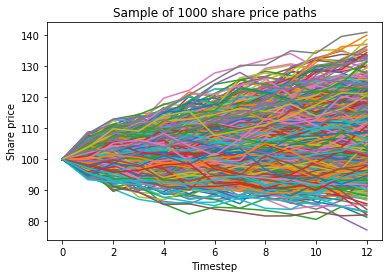

In [102]:
plt.plot(share_price_paths[1000])
plt.xlabel('Timestep')
plt.ylabel('Share price')
plt.title('Sample of 1000 share price paths')
plt.show()

# Part 3

In [103]:
price_estimate = []
price_std = []

for size in sample_sizes:
    S_Ts = share_price_paths[size].iloc[12, :]
    payoff = np.maximum(S_Ts - K, 0)
    discounted_price = np.exp(-r*T)*payoff
    price_estimate.append(discounted_price.mean())
    price_std.append(discounted_price.std()/np.sqrt(size))

# Part 4

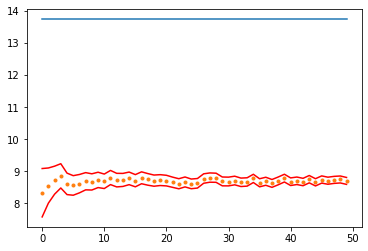

In [104]:
plt.plot([fourier_call_val]*50, label='Fourier Call price')
plt.plot(price_estimate, '.', label='Monte Carlo estimates')
plt.plot(price_estimate + 3*np.array(price_std), 'r')
plt.plot(price_estimate - 3*np.array(price_std), 'r')

In [62]:
payoff = np.maximum(share_price_paths[1000].iloc[12, :] - K, 0)
payoff.mean()

5.396893606281493

In [60]:
payoff.mean()

5.5892038700422955